In [3]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))
from scipy.io import loadmat
from pathlib import Path
import matplotlib.patches as patches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
# the following import is required for matplotlib < 3.2:
from mpl_toolkits.mplot3d import Axes3D  # noqa
from scipy import stats
from scipy.stats import mannwhitneyu, ttest_rel
from scipy.signal import butter, filtfilt
import mne
import eeg_analysis.funcs4eeg as fe
import re
import imp
import ast
import behavior.func4behav as fb
imp.reload(fe)
imp.reload(fb)

from scipy import signal
from scipy.signal import resample
from scipy.ndimage import zoom

In [4]:
case_title = 'endo valid'
case_list = [case_title+' fast', case_title+' slow']
if 'endo' in case_title:
    tmax_list = [1.5+1+0.5+0.05+1, 1.5+1+1+0.05+1]
else:
    tmax_list = [1.5+0.033*4+0.5+0.05+1, 1.5+0.033*4+1+0.05+1]

fs = 1200
for i, case in enumerate(case_list):
    tmax = tmax_list[i]
    watch = '1 fixation'
    tmin = 0 # include fix or not?

    highpass = None # 0.3
    lowpass = None

    EP_lists, RT_lists = fe.pipeline_session_RT(case, watch, tmin, tmax, hipass=highpass, lopass=lowpass, baseline=(0,0), move_baseline=False, detrend=1)

    if 'slow' in case:
        sessions_slow = EP_lists
        rts_slow = RT_lists
    else:
        sessions_fast = EP_lists
        rts_fast = RT_lists


In [5]:
eegs_list = [sessions_fast, sessions_slow]
rts_list = [rts_fast, rts_slow]
session_names = ["sham before", "sham after", "real before", "real after"]
freq_band_names = ["theta", "alpha", "beta", "gamma"]
region_names = ["frontal", "central", "parietal", "occipital", "temporal"] # , "all"]
stage_names_endo = ["fixation", "cue", "wait", "response", "until response"]
stage_names_exo = ["fixation", "wait", "response", "until response"]
freq_bands = [[4, 8], [8, 12], [12, 30], [30, 50]]
endo_fast_stages = [[0, 1.5], [1.5, 1.5+1], [1.5+1, 1.5+1+0.5], [1.5+1+0.5+0.05, 1.5+1+0.5+0.05+0.3], [0, 1.5+1+0.5+0.05]]
endo_slow_stages = [[0, 1.5], [1.5, 1.5+1], [1.5+1, 1.5+1+1], [1.5+1+1+0.05, 1.5+1+1+0.05+0.3], [0, 1.5+1+1+0.05]]
exo_fast_stages = [[0, 1.5], [1.5+0.033*4, 1.5+0.033*4+0.5], [1.5+0.033*4+0.5+0.05, 1.5+0.033*4+0.5+0.05+0.3], [0, 1.5+0.033*4+0.5+0.05]]
exo_slow_stages = [[0, 1.5], [1.5+0.033*4, 1.5+0.033*4+1], [1.5+0.033*4+1+0.05, 1.5+0.033*4+1+0.05+0.3], [0, 1.5+0.033*4+1+0.05]]

if 'endo' in case_title:
    stages_list = [endo_fast_stages, endo_slow_stages]
    stage_names = stage_names_endo
else:
    stages_list = [exo_fast_stages, exo_slow_stages]
    stage_names = stage_names_exo
bp_rt = pd.DataFrame(columns=['stage', 'band', 'region', 'session', 'group_id', 'band power', 'reaction time'])

In [6]:
for i, sessions in enumerate(eegs_list):
    rts = rts_list[i]
    stage_list = stages_list[i]
    for j, session_name in enumerate(session_names):
        session_eeg = sessions[j]
        session_rt = rts[j]
        # print(session_name)
        for group_id in range(9):
            # print(group_id)
            eeg = session_eeg[group_id]
            rt = session_rt[group_id]
            for trial in range(eeg.shape[0]):
                trial_data = eeg[trial,:,:]
                for k, stage in enumerate(stage_list):
                    stage_start = int(stage[0]*fs)
                    stage_end = int(stage[1]*fs)
                    psds, freqs = mne.time_frequency.psd_array_multitaper(trial_data[:,stage_start:stage_end], fs, fmin=1, fmax=51, verbose=False)
                    for l, freq_band in enumerate(freq_bands):
                        bp = fe.band_power(psds, freqs, freq_band)
                        for region in region_names:
                            channels_dict = fe.pick_cortex(region)
                            channel_names_list = list(channels_dict.keys())
                            channels = [channels_dict[key]-1 for key in channel_names_list]
                            bp_region = np.nanmean(bp[channels])
                            new_row = pd.DataFrame({
                                'stage': [stage_names[k]],
                                'band': [freq_band_names[l]],
                                'region': [region],
                                'session': [session_name],
                                'group_id': [group_id],
                                'band power': [bp_region],
                                'reaction time': [rt[trial]]
                            })
                            bp_rt = pd.concat([bp_rt, new_row], ignore_index=True)
bp_rt
# 11 min 32 s for endo or exo
# 42 s for endo invalid
# 6 min 7.7 s for endo valid

,stage,band,region,session,group_id,band power,reaction time
0,fixation,theta,frontal,sham before,0,4.917636e-09,0.42679
1,fixation,theta,central,sham before,0,6.879493e-09,0.42679
2,fixation,theta,parietal,sham before,0,4.384868e-09,0.42679
3,fixation,theta,occipital,sham before,0,3.601555e-09,0.42679
4,fixation,theta,temporal,sham before,0,4.997879e-09,0.42679
...,...,...,...,...,...,...,...
165195,until response,gamma,frontal,real after,8,1.310115e-09,0.27778
165196,until response,gamma,central,real after,8,1.048762e-09,0.27778
165197,until response,gamma,parietal,real after,8,1.208744e-09,0.27778
165198,until response,gamma,occipital,real after,8,8.794468e-10,0.27778


In [69]:
bp_rt_session = pd.DataFrame(columns=['stage', 'band', 'region', 'session', 'group id', 'band power', 'reaction time'])
# bp_lower_k = [10, 10, 0.6, 10]
# bp_upper_k = [10, 10, 10, 1.5]
# rt_lower_k = [10, 10, 0.6, 10]
# rt_upper_k = [10, 10, 10, 1.5]
for stage in stage_names:
    for band in freq_band_names:
        for region in region_names:
            for i, session in enumerate(session_names):
                for group_id in range (9):
                    bps = bp_rt[(bp_rt['stage']==stage) & (bp_rt['band']==band) & (bp_rt['region']==region) & (bp_rt['session']==session) & (bp_rt['group_id']==group_id)]['band power'].values
                    # bps = fe.rm_outlier(bps, lower_k=bp_lower_k[i], upper_k=bp_upper_k[i]) # , verbose=True)
                    bp_mean = np.array(bps).mean()
                    rts = bp_rt[(bp_rt['stage']==stage) & (bp_rt['band']==band) & (bp_rt['region']==region) & (bp_rt['session']==session) & (bp_rt['group_id']==group_id)]['reaction time'].values
                    # rts = fe.rm_outlier(rts, lower_k=rt_lower_k[i], upper_k=rt_upper_k[i])
                    rt_mean = np.array(rts).mean()
                    
                    new_row = pd.DataFrame({
                        'stage': [stage],
                        'band': [band],
                        'region': [region],
                        'session': [session],
                        'group id': [group_id],
                        'band power': [bp_mean],
                        'reaction time': [rt_mean]
                    })
                    bp_rt_session = pd.concat([bp_rt_session, new_row], ignore_index=True)
bp_rt_session
# 5 m 23.3 s for endo or exo
# 1 m 2.9 s for endo invalid
# 4 m 9.4 s for endo valid

,stage,band,region,session,group id,band power,reaction time
0,fixation,theta,frontal,sham before,0,5.727070e-09,0.352201
1,fixation,theta,frontal,sham before,1,2.345406e-09,0.267132
2,fixation,theta,frontal,sham before,2,6.033004e-09,0.323216
3,fixation,theta,frontal,sham before,3,9.607870e-09,0.299883
4,fixation,theta,frontal,sham before,4,6.496431e-08,0.284844
...,...,...,...,...,...,...,...
3595,until response,gamma,temporal,real after,4,4.362621e-09,0.303814
3596,until response,gamma,temporal,real after,5,3.200602e-09,0.259178
3597,until response,gamma,temporal,real after,6,2.278390e-09,0.313521
3598,until response,gamma,temporal,real after,7,1.440774e-09,0.350894


In [70]:
ccp_roi = bp_rt_session[(bp_rt_session['session']=='real before') | (bp_rt_session['session']=='real after')]
ccp_table = pd.DataFrame(columns=['stage', 'band', 'region', 'cc', 'p'])
for stage in stage_names:
    for band in freq_band_names:
        for region in region_names:
            bps = ccp_roi[(ccp_roi['stage']==stage) & (ccp_roi['band']==band) & (ccp_roi['region']==region)]['band power'].values
            rts = ccp_roi[(ccp_roi['stage']==stage) & (ccp_roi['band']==band) & (ccp_roi['region']==region)]['reaction time'].values
            # bps, rts = remove_outliers(case_title, bps, rts)
            cc, p = stats.pearsonr(bps, rts)
            new_row = pd.DataFrame({
                'stage': [stage],
                'band': [band],
                'region': [region],
                'cc': [cc],
                'p': [p]
            })
            ccp_table = pd.concat([ccp_table, new_row], ignore_index=True)


ccp_table.sort_values(by=['cc'], ascending=False).head(10)

,stage,band,region,cc,p
92,until response,beta,parietal,0.451462,0.060019
12,fixation,beta,parietal,0.412661,0.088774
93,until response,beta,occipital,0.372721,0.127683
52,wait,beta,parietal,0.360751,0.141368
11,fixation,beta,central,0.312052,0.207437
94,until response,beta,temporal,0.309803,0.210905
91,until response,beta,central,0.309659,0.211128
13,fixation,beta,occipital,0.305563,0.217545
90,until response,beta,frontal,0.283652,0.254011
32,cue,beta,parietal,0.283365,0.254512


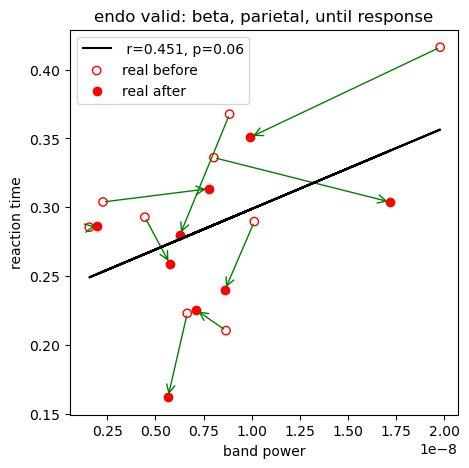

In [71]:
import matplotlib.patches as mpatches

stage = "until response"
band = "beta"
region = "parietal"
bp_rt_roi = bp_rt_session[(bp_rt_session['stage']==stage) & (bp_rt_session['band']==band) & (bp_rt_session['region']==region)]
bp_rt_roi = bp_rt_roi[(bp_rt_roi['session']=='real before') | (bp_rt_roi['session']=='real after')]

bp_rb, rt_rb = bp_rt_roi[bp_rt_roi['session']=='real before']['band power'].values, bp_rt_roi[bp_rt_roi['session']=='real before']['reaction time'].values
bp_ra, rt_ra = bp_rt_roi[bp_rt_roi['session']=='real after']['band power'].values, bp_rt_roi[bp_rt_roi['session']=='real after']['reaction time'].values

# Concatenate all the updated band power and reaction time arrays for regression
bp = np.concatenate((bp_rb, bp_ra))
rt = np.concatenate((rt_rb, rt_ra))

# Recalculate the regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(bp, rt)
line = slope*bp+intercept

# Update the plot
plt.figure(figsize=(5,5))
plt.plot(bp, line, 'k', label=' r='+str(round(r_value, 3))+', p='+str(round(p_value, 3)))

plt.scatter(bp_rb, rt_rb, label='real before', facecolors='none', edgecolors='r')
plt.scatter(bp_ra, rt_ra, label='real after', facecolors='r', edgecolors='r')

# Create an axes object
ax = plt.gca()

# Iterate over the unique 'group id's
for i in range(9):
    bp_from, rt_from = bp_rb[i], rt_rb[i]
    bp_to, rt_to = bp_ra[i], rt_ra[i]
    # Create a FancyArrowPatch object and add it to the axes
    arrow = mpatches.FancyArrowPatch((bp_from, rt_from), (bp_to, rt_to), color='green', arrowstyle='->', mutation_scale=15)
    ax.add_patch(arrow)

plt.legend()
plt.title(case_title+': '+band+', '+region+', '+stage)
plt.xlabel("band power")
plt.ylabel("reaction time")
plt.show()